In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------

# Load data
# Use pd.read_excel() since the file is an Excel file (.xlsx)
df = pd.read_excel("/content/Data_GHGE.xlsx")

# Feature selection
feature_columns = [
   'FP index ', 'LP index ', 'Vegetal Pds-FS', 'Cereals -FS',
       'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS', 'Fish-FS',
       'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS', 'Eggs-FS',
       'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF', 'Meat-LSF',
       'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS', 'Energy use',
       'Renewable energy '
]

In [133]:
df.columns

Index(['Indicator Code', 'FP index ', 'LP index ', 'Vegetal Pds-FS',
       'Cereals -FS', 'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS',
       'Fish-FS', 'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS',
       'Eggs-FS', 'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF',
       'Meat-LSF', 'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS',
       'Energy use', 'Renewable energy ', 'GHGEs ',
       'Agricultural land use share ', 'Agricultural water share ',
       'Surface temp.', 'Overweight', 'Obese', 'Death-NCD ',
       'Life expectancy '],
      dtype='object')

In [134]:
X = df[feature_columns].values
y = df[  'Surface temp.'].values

# Split data before scaling to prevent data leakage


X_train_raw= X[:51]
X_test_raw = X[51:]
y_train_raw= y[:51]
y_test_raw= y[51:]



# x_train = X_x[:52]
# x_test = X_x[52:]
# y_train = Y_data[:52]
# y_test = Y_data[52:]






# Initialize scalers
# feature_scaler = RobustScaler()
# target_scaler = RobustScaler()
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

In [135]:
y_test_raw

array([0.06064492, 0.06065208, 0.06066183, 0.06067276, 0.06070957,
       0.06076996, 0.060842  , 0.06092494, 0.06102614, 0.06112592])

In [136]:
# Fit scalers on training data
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
y_train_scaled = target_scaler.fit_transform(y_train_raw.reshape(-1, 1))

# Transform test data
X_test_scaled = feature_scaler.transform(X_test_raw)
y_test_scaled = target_scaler.transform(y_test_raw.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, sequence_length=3):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length + 1):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i+sequence_length-1])
    return np.array(sequences_X), np.array(sequences_y)

# Create sequences in training data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length=3)

# Create sequences in test data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length=3)


In [137]:
# 2. Build the Bidirectional LSTM Model
# ---------------------------

from tensorflow.keras.layers import Bidirectional

# Build the Stacked LSTM model
model = Sequential()
# First LSTM layer - Changed input_shape to match X_train_seq features
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer (stacked)
model.add(LSTM(units=150, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer (stacked)
model.add(LSTM(units=150))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [138]:
#  Define custom metric
def correlation_coefficient(y_true, y_pred):
    x = y_true - K.mean(y_true)
    y = y_pred - K.mean(y_pred)
    numerator = K.sum(x * y)
    denominator = K.sqrt(K.sum(K.square(x)) * K.sum(K.square(y)))
    return numerator / (denominator + K.epsilon())

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', correlation_coefficient]
)


In [139]:
# 4. Train the Model
# ---------------------------

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_correlation_coefficient', mode='max', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=700,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - correlation_coefficient: 0.3859 - loss: 0.7699 - mae: 0.7487 - val_correlation_coefficient: -0.8467 - val_loss: 1.0428 - val_mae: 1.0011 - learning_rate: 0.0010
Epoch 2/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - correlation_coefficient: 0.8414 - loss: 0.4505 - mae: 0.5734 - val_correlation_coefficient: -0.8300 - val_loss: 0.6600 - val_mae: 0.7744 - learning_rate: 0.0010
Epoch 3/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - correlation_coefficient: 0.8462 - loss: 0.1664 - mae: 0.3213 - val_correlation_coefficient: -0.8060 - val_loss: 0.4211 - val_mae: 0.5860 - learning_rate: 0.0010
Epoch 4/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - correlation_coefficient: 0.8708 - loss: 0.1344 - mae: 0.3018 - val_correlation_coefficient: -0.7820 - val_loss: 0.6168 - val_mae: 0.7434 - learning_rate: 0.0010
Epoch 5/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - correlation_coefficient: 0.8695 - loss: 0.0806 - mae: 0.2279 - val_correlation_coefficient: -0

In [140]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = target_scaler.inverse_transform(y_test_seq)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

r2 = r2_score(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmae= np.sqrt(mean_absolute_error(y_test_unscaled, y_pred))
corr_coef = np.corrcoef(y_test_unscaled.flatten(), y_pred.flatten())[0,1]


residual_en = np.abs(y_test_unscaled-y_pred)
R2 = 1 - (residual_en/np.sum(np.sqrt(residual_en)))
np.average(R2)
print('R2 :'," ", np.average(R2))



print("\nTest Metrics:")
print('R2 :'," ", np.average(R2))
# print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMAE:{rmae:.4f}")

print(f"\nPrediction Range:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")

print(f"\nCorrelation coefficient: {corr_coef:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
R2 :   0.9969403797133832

Test Metrics:
R2 :   0.9969403797133832
RMSE: 0.0006
MAE: 0.0006
RMAE:0.0240

Prediction Range:
Min: 0.0601, Max: 0.0604

Correlation coefficient: -0.5377


In [141]:
y_test_unscaled

array([[0.06066183],
       [0.06067276],
       [0.06070957],
       [0.06076996],
       [0.060842  ],
       [0.06092494],
       [0.06102614],
       [0.06112592]])

In [142]:
y_pred

array([[0.06022704],
       [0.06025897],
       [0.06039668],
       [0.06039122],
       [0.06028775],
       [0.0601972 ],
       [0.0601202 ],
       [0.0602309 ]], dtype=float32)

In [143]:
import seaborn as sns



<Figure size 640x480 with 0 Axes>

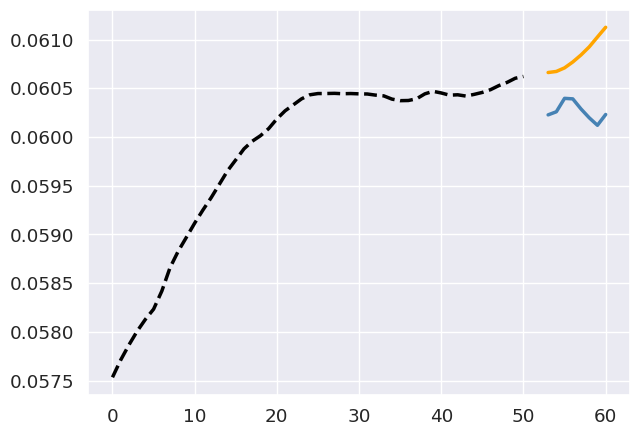

In [144]:
plt.figure(1)
# plt.style.use('seaborn')
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)
plt.plot(y_train_raw,'--', color='black',markersize=12, linewidth=2.5)
plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=2.5)
plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=2.5)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Surface temp. change,\N{DEGREE SIGN}C')
# # plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# # plt.ylim(70, 80)
# plt.legend(['Surface temp. change (train set)','Surface temp. change(test set)','LSTM model prediction'  ])

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# plt.savefig("Surface temp. change_LSTM.png", dpi = 1000, bbox_inches='tight')

In [145]:
df[52:]

,Indicator Code,FP index,LP index,Vegetal Pds-FS,Cereals -FS,Starchy Rts-FS,Pulses-FS,Fruits -FS,Meat-FS,Fish-FS,...,Energy use,Renewable energy,GHGEs,Agricultural land use share,Agricultural water share,Surface temp.,Overweight,Obese,Death-NCD,Life expectancy
52,2013,95.84,98.85,2697,783,102,37,130,431,28,...,6905.598633,7.134616,19.724750,44.124682,38.141533,0.060652,65.800000,34.700000,30.840206,78.9507
53,2014,98.16,99.02,2734,788,102,30,118,428,28,...,6960.683997,7.262891,19.774370,44.184360,38.886310,0.060662,66.400000,35.400000,30.755196,79.0175
54,2015,96.99,98.61,2731,790,99,31,121,435,29,...,6803.996607,7.468743,19.143078,44.244027,39.658783,0.060673,66.900000,36.000000,30.838190,78.8694
55,2016,104.85,102.38,2743,783,102,32,130,441,28,...,6906.045291,8.285085,18.617743,44.303705,39.658783,0.060710,67.400000,36.700000,30.633383,78.8482
56,2017,101.95,105.14,2752,782,103,32,146,445,29,...,6865.181738,9.082048,18.431720,44.363367,39.658783,0.060770,67.900000,37.300000,30.534817,78.8213
57,2018,103.35,108.11,2743,795,102,32,153,488,29,...,6206.663228,8.964108,18.884752,44.363367,39.658783,0.060842,68.737227,37.533824,30.594480,78.9896
58,2019,100.09,109.27,2782,802,100,31,155,499,30,...,6563.464324,9.314181,18.479849,44.363367,39.658783,0.060925,69.544949,37.914569,30.099432,79.1380
59,2020,104.45,111.14,2801,814,101,44,144,510,30,...,7661.265745,10.528127,16.749628,44.363367,40.231326,0.061026,70.651154,38.130126,26.972640,77.4144
60,2021,105.00,112.00,2818,818,95,46,148,508,30,...,7891.000000,10.506885,17.583845,44.363367,40.653711,0.061126,70.903764,38.698860,27.372815,77.1982


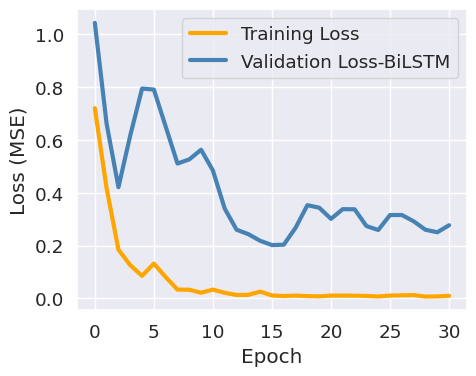

In [146]:
# Plot training & validation loss
# plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=3, color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss-BiLSTM', linewidth=3, color='steelblue')
# plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
# plt.savefig('Bidirection on GHGE_validation_loss.png', dpi = 1000, bbox_inches='tight')
plt.show()

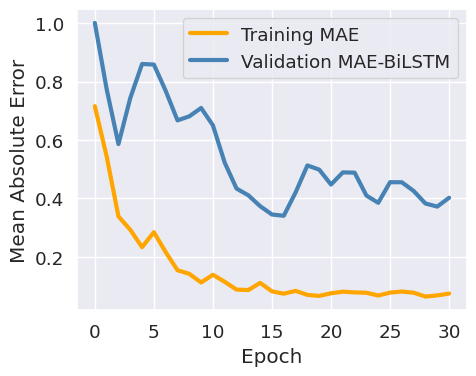

In [147]:
# Plot training & validation MAE
# plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)

plt.figure(figsize=(5,4))
plt.plot(history.history['mae'], label='Training MAE', linewidth=3, color='orange')
plt.plot(history.history['val_mae'], label='Validation MAE-BiLSTM', linewidth=3, color='steelblue')
# plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
# plt.savefig('Bidirection on GHGE_MAE_loss.png', dpi = 1000, bbox_inches='tight')
plt.show()